In [1]:
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Divide the annotation file into multiple .txt files for each image
# Define the paths
annotation_path = "./grocery_annotations/annotation.txt"
image_dir = "./Images_Grocery/ShelfImages/"

# Open the annotation file
with open(annotation_path, 'r') as f:
    lines = f.readlines()

# Process each line
for line in lines:
    parts = line.split()
    image_name = parts[0]
    num_objects = int(parts[1])
    objects = [parts[i:i+5] for i in range(2, len(parts), 5)]

    # Create a new annotation file for this image
    with open(os.path.join(image_dir, image_name + '.txt'), 'w') as f:
        for obj in objects:
            # Write the object annotation to the file
            f.write(' '.join(obj) + '\n')

In [3]:
from sklearn.model_selection import train_test_split

def list_files(full_data_path = "./Images_Grocery/ShelfImages/", image_ext = '.JPG', test_size = 0.15, validation_size = 0.15):

    files = []

    for r, d, f in os.walk(full_data_path):
        for file in f:
            if file.endswith(image_ext):
                files.append(file)

    # Split the data into training and testing
    train_files, test_files = train_test_split(files, test_size=test_size, random_state=42)

    # Split the training data into training and validation
    train_files, val_files = train_test_split(train_files, test_size=validation_size, random_state=42)

    return train_files, val_files, test_files

In [4]:
training_files, validation_files, test_files = list_files()

print(str(len(training_files)) + " training files")
print(str(len(validation_files)) + " validation files")
print(str(len(test_files)) + " test files")

255 training files
45 validation files
53 test files


In [5]:
input_size = 244
new_size = (244, 244)  # New size (height, width)

def resize_image_and_box(img, box):
    # Calculate the scale factors
    y_scale = input_size / img.shape[0]
    x_scale = input_size / img.shape[1]

    # Resize the image
    resized_img = cv2.resize(img, new_size)

    x, y, w, h = box[0], box[1], box[2], box[3]
    #new_box = [int(x / r), int(y / r), int(w / r), int(h / r)]
    
    # Scale the bounding box coordinates
    resized_box = [int(box[0] * x_scale), int(box[1] * y_scale), int(box[2] * x_scale), int(box[3] * y_scale)]

    return resized_img, resized_box

def format_image(img1, box1):
    img = img1.copy()
    box = box1.copy()
    height, width = img.shape
    max_size = max(height, width)
    r = max_size / input_size
    new_width = int(width / r)
    new_height = int(height / r)
    new_size = (new_width, new_height)
    resized = cv2.resize(img, new_size, interpolation= cv2.INTER_AREA)
    new_image = np.zeros((input_size, input_size), dtype=np.uint8)
    new_image[0:new_height, 0:new_width] = resized

    x, y, w, h = box[0], box[1], box[2], box[3]
    new_box = [int(x / r), int(y / r), int(w / r), int(h / r)]
    
    return new_image, new_box

In [6]:
class CustomDataset(Dataset):
    def __init__(self, images_folder, transform=None):
        self.dataset = self.create_dataset(images_folder)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        entry = self.dataset[idx]

        # If you want to apply any image transformations
        if self.transform:
            entry["image"] = self.transform(entry["image"])

        # Convert to PyTorch tensor
        image = transforms.ToTensor()(entry["image"])

        # Convert bounding boxes and class labels to tensors
        bounding_boxes = torch.tensor(entry["bounding_boxes"], dtype=torch.int64)
        class_labels = torch.tensor(entry["class_label"], dtype=torch.int64)

        # Create target dictionary
        target = {
            'boxes': bounding_boxes,
            'labels': class_labels
        }

        return image, target
    
    def create_dataset(self, files, full_data_path = "./Images_Grocery/ShelfImages/"):
        dataset = []
        
        for file in files:
            # Load the image in grayscale
            img = cv2.imread(os.path.join(full_data_path, file), cv2.IMREAD_GRAYSCALE)
            k = 1
            labels = []
            with open(os.path.join(full_data_path, file + ".txt"), 'r') as fp:
                lines = fp.readlines()
                boxes = []
                for line in lines:
                    parts = line.split()
                    box = np.array(parts[:4], dtype=int)
                    xmin = box[0]
                    ymin = box[1]
                    xmax = box[0] + box[2]
                    ymax = box[1] + box[3]
                    box[0] = xmin
                    box[1] = ymin
                    box[2] = xmax
                    box[3] = ymax
                    if(box[0] == 0):
                        box[0] = 0.1
                    copy_img, box = format_image(img, box)
                    #copy_img = copy_img.astype(int) / 255
                    boxes.append(box)
                    labels.append(k)
                    
                dataset.append({
                    "image": copy_img,
                    "bounding_boxes": boxes,
                    "class_label": labels
                })

        return dataset


#custom_dataset = CustomDataset(training_files)
custom_dataset = CustomDataset(test_files)

# Example: Using DataLoader
dataloader = DataLoader(custom_dataset, batch_size=1, shuffle=True, num_workers=0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


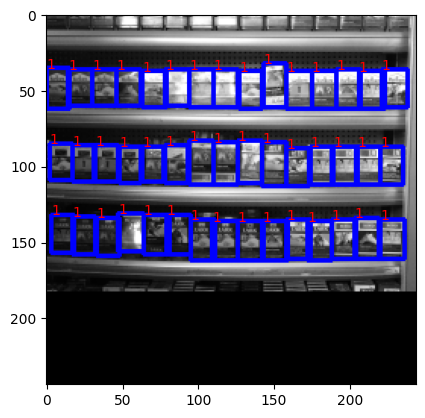

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Get the first batch from the dataloader
first_batch = next(iter(dataloader))

# Get the first image, bounding boxes, and labels from the batch
images = first_batch[0]
targets = first_batch[1]
#class_labels = first_batch['class_label']

# Convert the image tensor to a numpy array and transpose the dimensions for matplotlib
image = images[0].squeeze(0).squeeze(0)

# Convert the image to float32
image = image.numpy().astype(np.float32)

# Convert the grayscale image to RGB
temp_color_img = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

# Get the first bounding box and convert it to numpy
boxes = targets['boxes'][0].numpy()
labels = targets['labels'][0].numpy()
for box, label in zip(boxes, labels):
    xmin, ymin, xmax, ymax = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    cv2.rectangle(temp_color_img, (xmin, ymin), (xmax, ymax), (0, 0, 255), 2)
    plt.text(xmin, ymin, str(label), color='red')
plt.imshow(temp_color_img)
# for box, label in zip(boxes, labels):
#     x, y, w, h = int(box[0]),int(box[1]), int(box[2]), int(box[3])
#     cv2.rectangle(temp_color_img, (x, y), (x+w, y+h), (0, 0, 255), 2)
#     plt.text(x, y, str(label), color='red')
# plt.imshow(temp_color_img)

In [9]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
device = torch.device('cpu') if torch.cuda.is_available() else torch.device('cpu')
# Load a pre-trained model for modification
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Replace the classifier with a new one, that has num_classes which is user-defined
num_classes = 2  # 1 class (your object) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Move model to the right device
model.to(device)

# Construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# And a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    # Train for one epoch, printing every 10 iterations
    for images, targets in dataloader:
        images = list(image.to(device) for image in images)
        #print(targets)
        
        boxes = targets['boxes'].squeeze(0)
        #print(boxes)
        targets = [{k: v.squeeze(0).to(device) for k, v in targets.items()}]
        loss_dict = model(images, targets)  # Returns losses and detections
        losses = sum(loss for loss in loss_dict.values())

        # Reduce losses over all GPUs for logging purposes
        loss_value = losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    # update the learning rate
    lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_value}")

Epoch #0 loss: 1.0005149841308594
Epoch #1 loss: 0.8179910182952881
Epoch #2 loss: 0.6766756176948547
Epoch #3 loss: 0.47050201892852783
Epoch #4 loss: 0.39875590801239014


In [10]:
custom_dataset1 = CustomDataset(validation_files)

# Example: Using DataLoader
dataloader1 = DataLoader(custom_dataset1, batch_size=1, shuffle=True, num_workers=0)


In [13]:
def calculate_iou(box1, box2):
    """Calculate intersection over union (IoU) between two bounding boxes with the format [x,y,width,height]."""
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    # Calculate the (x, y)-coordinates of the intersection rectangle
    xA = max(x1, x2)
    yA = max(y1, y2)
    xB = min(x1+w1, x2+w2)
    yB = min(y1+h1, y2+h2)

    # Compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # Compute the area of both the prediction and ground-truth rectangles
    box1Area = w1 * h1
    box2Area = w2 * h2

    # Compute the intersection over union by taking the intersection area and dividing it by the sum of prediction + ground-truth areas - the intersection area
    iou = interArea / float(box1Area + box2Area - interArea)

    # return the intersection over union value
    return iou

In [15]:
import matplotlib.pyplot as plt
import cv2

# Assuming you have a test_dataloader for your test dataset
model.eval()  # Set the model to evaluation mode

iou_threshold = 0.5  # Commonly used IoU threshold
total = 0
correct = 0

with torch.no_grad():  # No need to calculate gradients
    for images, targets in dataloader1:
        images = list(image.to(device) for image in images)
        targets = [{k: v.squeeze(0).to(device) for k, v in targets.items()}]

        # Get model predictions
        predictions = model(images)

        # Now you need to compare predictions to the actual values
        for i, (pred, target) in enumerate(zip(predictions, targets)):
            pred_boxes = pred['boxes']
            target_boxes = target['boxes']

            for pred_box, target_box in zip(pred_boxes, target_boxes):
                # Calculate IoU
                iou = calculate_iou(pred_box, target_box)  # You need to implement this function

                total += 1
                if iou > iou_threshold:
                    correct += 1

                # Convert the image from Tensor to numpy array and then to uint8
                img = images[i].permute(1, 2, 0).cpu().numpy()
                img = (img * 255).astype(np.uint8)

                # Draw the bounding boxes on the image
                cv2.rectangle(img, (pred_box[0], pred_box[1]), (pred_box[2], pred_box[3]), (0, 255, 0), 2)
                cv2.rectangle(img, (target_box[0], target_box[1]), (target_box[2], target_box[3]), (255, 0, 0), 2)

                # Display the image
                plt.imshow(img)
                plt.title(f'IoU: {iou:.2f}')
                plt.show()

print(f'Accuracy: {correct / total}')

error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type
>  - Can't parse 'rec'. Expected sequence length 4, got 2
>  - Can't parse 'rec'. Expected sequence length 4, got 2
